# TP Data Science - Apprentissage Surpevisé


## Etude du jeu de données "Mushroom"

In [2]:
# Import des librairies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import graphviz
plt.ion()

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score

import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
plt.style.use('seaborn-darkgrid')

## Données

In [85]:
# Import
df_mushrooms = pd.read_csv('data/df_mushrooms.csv', delimiter = ';')
print("Nombre de colonnes :", len(df_mushrooms.columns))
print("Nombre de lignes :", len(df_mushrooms.values))
df_mushrooms

Nombre de colonnes : 23
Nombre de lignes : 8124


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [86]:
# Séparation des observations et classe
X = df_mushrooms.drop('class', axis = 1)
y = df_mushrooms['class']

# Codage des classes : edible = 0, poisonous = 1 
print("Classes étudiées :", pd.unique(y))
y = y.replace('e', 0)
y = y.replace('p', 1)

df_mushrooms['class'].value_counts()

Classes étudiées : ['p' 'e']


e    4208
p    3916
Name: class, dtype: int64

In [87]:
print("Valeurs possibles pour chaque feature :")
for x in X:
    print("{} : {}".format(x, pd.unique(X[x])))

Valeurs possibles pour chaque feature :
cap-shape : ['x' 'b' 's' 'f' 'k' 'c']
cap-surface : ['s' 'y' 'f' 'g']
cap-color : ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises : ['t' 'f']
odor : ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment : ['f' 'a']
gill-spacing : ['c' 'w']
gill-size : ['n' 'b']
gill-color : ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape : ['e' 't']
stalk-root : ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring : ['s' 'f' 'k' 'y']
stalk-surface-below-ring : ['s' 'f' 'y' 'k']
stalk-color-above-ring : ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring : ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type : ['p']
veil-color : ['w' 'n' 'o' 'y']
ring-number : ['o' 't' 'n']
ring-type : ['p' 'e' 'l' 'f' 'n']
spore-print-color : ['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population : ['s' 'n' 'a' 'v' 'y' 'c']
habitat : ['u' 'g' 'm' 'd' 'p' 'w' 'l']


<font size="1">
    Prenons connaissance de la signification des features :
    
- **cap-shape**: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
- **cap-surface**: fibrous=f,grooves=g,scaly=y,smooth=s
- **cap-color**: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
- **bruises**: bruises=t,no=f
- **odor**: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s
- **gill-attachment**: attached=a,descending=d,free=f,notched=n
- **gill-spacing** close=c,crowded=w,distant=d
- **gill-size**: broad=b,narrow=n
- **gill-color**: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o, pink=p,purple=u,red=e,white=w,yellow=y
- **stalk-shape**: enlarging=e,tapering=t
- **stalk-root**: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?
- **stalk-surface-above-ring**: fibrous=f,scaly=y,silky=k,smooth=s
- **stalk-surface-below-ring**: fibrous=f,scaly=y,silky=k,smooth=s
- **stalk-color-above-ring**: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
- **stalk-color-below-ring**: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
- **veil-type**: partial=p,universal=u
- **veil-color**: brown=n,orange=o,white=w,yellow=y
- **ring-number**: none=n,one=o,two=t
- **ring-type**: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
- **spore-print-color**: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
- **population**: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
- **habitat**: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d
</font>

La colonne *veil-type* est constante dans notre jeu de donnée. On doit la retirer car elle n'ajoute aucune information et risque d'influencer négativement nos modèles.

In [88]:
X = X.drop('veil-type', axis = 1)

## Encodage des données quantitatives<br>

Pour pouvoir manipuler les données, il est nécessaire de transformer les données quantitatives en données qualitatives. Pour cela, on encode les observations selon cette logique :

1. On regarde le nombre de valeurs pouvant être prise par chaque feature.
2. On considère chaque feature comme un vecteur de cette taille.
3. Une observation sera un vecteur dont la composante associée vaudra 1 et les autres 0.

> Exemple : feature *cap-surface*
> 1. Cette feature a 4 valeurs possibles : [s, y, f, g]
> 2. Le vecteur de cette feature est de taille 4
> 3. L'observation 's' sera codée : [1, 0, 0, 0]

Une fonction fournie par la librairie pandas permet de résumer toute cette logique en une seule opération, et éclate chaque vecteur en plusieurs colonnes :

In [89]:
X_qual = pd.get_dummies(X, prefix_sep='_')
X_qual.head()

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


## Sélection des features

Notre modélisation a fortement augmenté le nombre de features. Afin d'assurer la fiabilité de notre analyse, il est nécessaire de sélectionner les features les plus importantes. Ceci aura pour effet de généraliser notre analyse et de réduire le sur-apprentissage. Dans le TP précédent, nous avions réalisé une sélection manuelle selon les histogrammes des valeurs, suivie d'une analyse de la multi-colinéarité + VIF. Ici, nous nous intéresserons à une méthode très populaire en machine learning : les Random Forest. 

### Sélection par Random Forest

De fait de leur construction, les Random Forest permettent de bonnes prédictions en limitant le sur-apprentissage. De plus, ils permettent de faire remonter les features importantes : les features se trouvant dans la partie supérieure des arbres fournissent beaucoup d'informations car elles séparent la décision en deux, ce qui est par définition signe d'une feature a priori très pertinente.

> **Méthode :**
> 1. Entrainer le modèle Random Forest sur les données d'entrainement
> 2. Récupérer le taux d'importance chaque feature dans les Decision Tree.
> 3. Conserver les features selon un certain seuil d'importance.
> 4. Si le seuil est trop bas, la sélection ne sera pas assez discriminante. On peut le choisir empyriquement en s'appuyant sur la performance des modèles utilisés plus tard dans ce notebook.

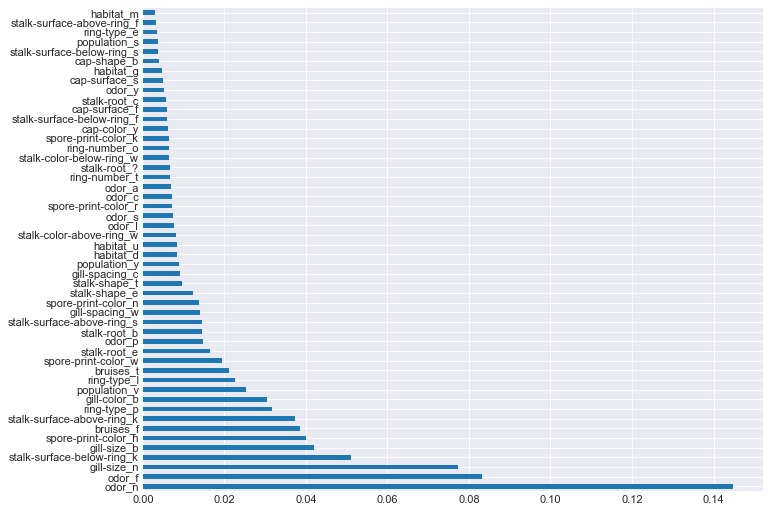

In [90]:
# Normalisation des données :
X_norm = StandardScaler().fit_transform(X_qual)

# Séparation entre données d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size = 0.33)

# Instanciation du modèle Random Forest
clf = RandomForestClassifier(n_estimators=100)

# Entrainement du modèle 
clf.fit(X_train, y_train);

# Affichage de l'importance des 50 meilleures features :
plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')
feat_importances = pd.Series(clf.feature_importances_, index= X_qual.columns)
feat_importances.nlargest(50).plot(kind='barh');

On remarque graphiquement qu'une grande majorité des données se trouvent sous le seuil d'importance 0.02 : on choisit cette valeur dans un premier temps pour la suite de l'analyse, en se conservant la possibilité de la changer selon les résultats.

Edit après analyse empirique : 

- Le seuil fixé à 0.02 a engendré de bons résultats.
- En le fixant à 0.01, nous avions remarqué un fort sur-apprentissage.
- Nous avons finalement choisi de le fixer à 0.15 : ceci a légèrement réduit l'accuracy mais a grandement atténué le sur-apprentissage.

In [135]:
# Seuil d'importance 
seuil = 0.015

# Sélection des features :
feat_selected = feat_importances[feat_importances > seuil].index
X_selected = X_qual[X_qual.columns.intersection(feat_selected)]
X_selected

,bruises_f,bruises_t,odor_f,odor_n,gill-size_b,gill-size_n,gill-color_b,stalk-root_e,stalk-surface-above-ring_k,stalk-surface-below-ring_k,ring-type_l,ring-type_p,spore-print-color_h,spore-print-color_w,population_v
0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
4,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0
8120,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1
8121,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0
8122,1,0,0,0,0,1,1,0,0,1,0,0,0,1,1


### Multi-corrélations

Il est également pertinent d'analyser les corrélations entre les features. Lors d'une trop grande corrélation, nous retirerons une des deux features. Nous nous servirons également du facteur d'Inflation de Variance pour orienter notre choix.

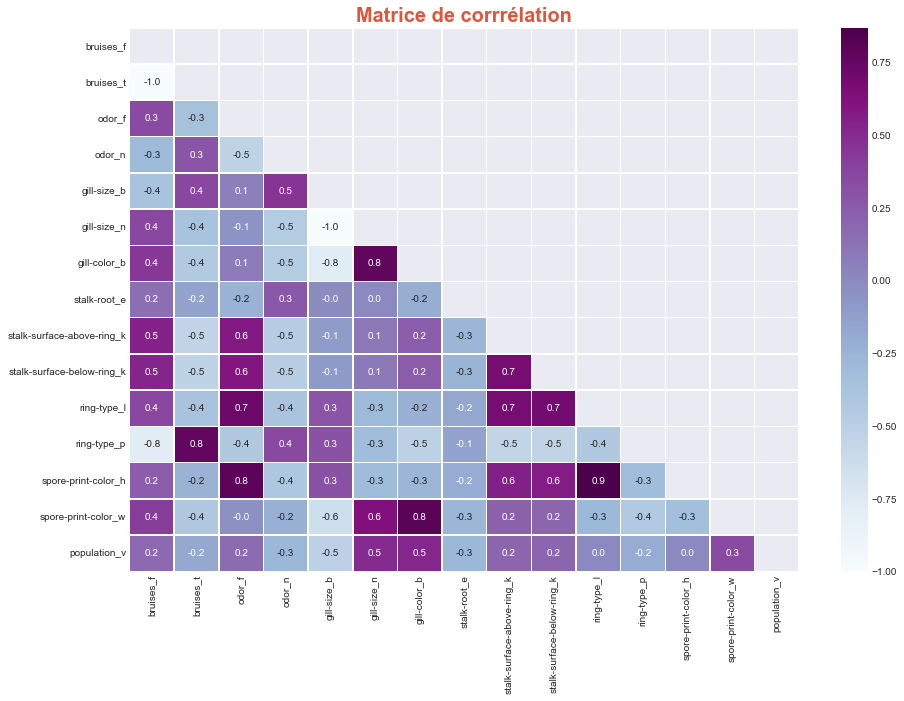

In [136]:
correlations = X_selected.corr()
masque = np.triu(np.ones_like(correlations, dtype = bool))

plt.figure(figsize=(15, 10))
sns.heatmap(correlations,
            mask = masque,
            cmap = 'BuPu',
            annot = True,
            linewidths = 0.5,
            fmt = ".1f")

plt.title('Matrice de corrrélation',
          fontsize = 20,
          weight = 'semibold',
          color = '#de573c'
         )

plt.show()

In [137]:
def VIF(df):
    vif = pd.DataFrame()
    vif['feature'] = df.columns
    values = np.array(df.values)
    vif['VIF'] = [variance_inflation_factor(values, col) for col in range(len(df.columns))]
    return vif

vif_df = VIF(X_selected).sort_values('VIF', ascending = False, ignore_index = True)
print(vif_df)

                       feature        VIF
0                    bruises_f        inf
1                    bruises_t        inf
2                  gill-size_b        inf
3                  gill-size_n        inf
4                  ring-type_l  11.360649
5                 gill-color_b   9.288517
6          spore-print-color_h   7.259648
7          spore-print-color_w   5.119809
8                  ring-type_p   4.665827
9                       odor_f   3.851633
10  stalk-surface-below-ring_k   3.170938
11                      odor_n   3.147534
12  stalk-surface-above-ring_k   2.999349
13                stalk-root_e   2.472199
14                population_v   1.789076


C:\Users\erebz\anaconda3\envs\data-science\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Le facteur d'inflation de Variance tend vers l'infini dans le cas d'une multi-colinéarité parfaite, ou très importante. On retire les 4 features qui sont dans ce cas et celles dont le VIF dépasse 10.

In [138]:
drop_features_vif = vif_df[vif_df['VIF'] > 10].feature 
X_selected = X_selected.drop(drop_features_vif, axis=1)

In [155]:
# Features conservées :
print('Features conservées :', X_selected.columns.values)
print('{}/{} features ont été conservées.'.format( len(X_selected.columns), len(X_qual.columns)))

Features conservées : ['odor_f' 'odor_n' 'gill-color_b' 'stalk-root_e'
 'stalk-surface-above-ring_k' 'stalk-surface-below-ring_k' 'ring-type_p'
 'spore-print-color_h' 'spore-print-color_w' 'population_v']
10/116 features ont été conservées.


Notre analyse sera portée sur les méthodes suivantes :
- Modèle Linéaire
- Perceptron Multi-couche
- Random Forest
- K plus proches voisins

### Découpage entre données d'apprentissage (66%) et de test (33%)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size = 0.33)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(len(X_train),'données d\'apprentissage')
print(len(X_test),'données de test')

5443 données d'apprentissage
2681 données de test


### Mesures d'évaluation

In [97]:
def printEval(predict_train, expected_train, predict_test, expected_test):
    _eval = precision_recall_fscore_support(expected_train, predict_train, average=None)
    print("Train")
    print("  - Precision 0 :", _eval[0][0].round(3))
    print("  - Precision 1 :", _eval[0][1].round(3))
    print("  - Recall 0 :", _eval[1][0].round(3))
    print("  - Recall 1 :", _eval[1][1].round(3))
    print("  - F-mesure 0 :", _eval[2][0].round(3))
    print("  - F-mesure 1 :", _eval[2][1].round(3))
    
    _eval = precision_recall_fscore_support(expected_test, predict_test, average=None)
    print("Test")
    print("  - Precision 0 :", _eval[0][0].round(3))
    print("  - Precision 1 :", _eval[0][1].round(3))
    print("  - Recall 0 :", _eval[1][0].round(3))
    print("  - Recall 1 :", _eval[1][1].round(3))
    print("  - F-mesure 0 :", _eval[2][0].round(3))
    print("  - F-mesure 1 :", _eval[2][1].round(3))

## Modèle linéaire

### Entrainement

In [141]:
# Initialisation du modèle
lda = LinearDiscriminantAnalysis()

# Entraînement du modèle
lda.fit(X_train, y_train)

# Evaluation des performances
ldaScore_train = "%.3f" % lda.score(X_train, y_train)
ldaScore_test = "%.3f" % lda.score(X_test, y_test)

print("Train:",ldaScore_train)
print("Test:",ldaScore_test)

Train: 0.951
Test: 0.960


In [158]:
printEval(lda.predict(X_train), y_train, lda.predict(X_test), y_test)

Train
  - Precision 0 : 0.919
  - Precision 1 : 0.994
  - Recall 0 : 0.995
  - Recall 1 : 0.904
  - F-mesure 0 : 0.955
  - F-mesure 1 : 0.947
Test
  - Precision 0 : 0.932
  - Precision 1 : 0.992
  - Recall 0 : 0.993
  - Recall 1 : 0.926
  - F-mesure 0 : 0.962
  - F-mesure 1 : 0.958


### Courbe ROC

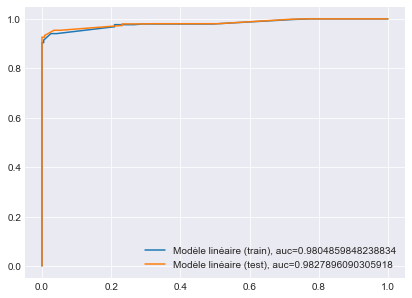

In [143]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
# AUC-ROC des données train :
y_pred_LDA_train = lda.predict_proba(X_train)[::,1]
fpr_LDA_train, tpr_LDA_train, _ = roc_curve(y_train, y_pred_LDA_train)
auc_LDA_train = roc_auc_score(y_train, y_pred_LDA_train)

# AUC-ROC des données test :
y_pred_LDA = lda.predict_proba(X_test)[::,1]
fpr_LDA, tpr_LDA, _ = roc_curve(y_test, y_pred_LDA)
auc_LDA = roc_auc_score(y_test, y_pred_LDA)

# Affichage courbe ROC + AUC
plt.plot(fpr_LDA_train,tpr_LDA_train,label="Modèle linéaire (train), auc="+str(auc_LDA_train))
plt.plot(fpr_LDA,tpr_LDA,label="Modèle linéaire (test), auc="+str(auc_LDA))
plt.legend(loc=4);

## Random Forest

Nous utilisons à nouveau un Random Forest. Lors de la sélection de variable, la précision (train/test) était de 100% car le trop grand nombre de feature a engendré un sur-apprentissage. On remarquera que cet effet s'est estompé après la sélection de feature.

### Entrainement

In [144]:
# Instanciation du modèle Random Forest
RF = RandomForestClassifier(n_estimators=100)

# Entrainement du modèle 
RF.fit(X_train, y_train);

# Evaluation des performances 
RF_Score_train = "%.3f" % RF.score(X_train, y_train)
RF_Score_test = "%.3f" % RF.score(X_test, y_test)

print("Train:",RF_Score_train)
print("Test:",RF_Score_test)

Train: 0.965
Test: 0.967


In [157]:
printEval(RF.predict(X_train), y_train, RF.predict(X_test), y_test)

Train
  - Precision 0 : 0.955
  - Precision 1 : 0.977
  - Recall 0 : 0.979
  - Recall 1 : 0.949
  - F-mesure 0 : 0.967
  - F-mesure 1 : 0.963
Test
  - Precision 0 : 0.962
  - Precision 1 : 0.972
  - Recall 0 : 0.973
  - Recall 1 : 0.961
  - F-mesure 0 : 0.967
  - F-mesure 1 : 0.966


### Courbe ROC

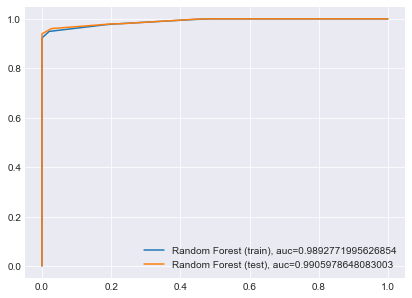

In [146]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
# AUC-ROC des données train :
y_pred_RF_train = RF.predict_proba(X_train)[::,1]
fpr_RF_train, tpr_RF_train, _ = roc_curve(y_train, y_pred_RF_train)
auc_RF_train = roc_auc_score(y_train, y_pred_RF_train)

# AUC-ROC des données test :
y_pred_RF_test = RF.predict_proba(X_test)[::,1]
fpr_RF, tpr_RF, _ = roc_curve(y_test, y_pred_RF_test)
auc_RF = roc_auc_score(y_test, y_pred_RF_test)

# Affichage courbe ROC + AUC
plt.plot(fpr_RF_train,tpr_RF_train,label="Random Forest (train), auc="+str(auc_RF_train))
plt.plot(fpr_RF,tpr_RF,label="Random Forest (test), auc="+str(auc_RF))
plt.legend(loc=4);

## Modèle PMC
### Entrainement

In [147]:
# PMC par défaut
defaultPMC = MLPClassifier(max_iter=1500)

# Entrainement
defaultPMC.fit(X_train, y_train)

# Evaluation des performances
defaultPMC_score_train = "%.3f" % defaultPMC.score(X_train, y_train)
defaultPMC_score_test = "%.3f" % defaultPMC.score(X_test, y_test)

print("PMC par défaut :")
print(" - Train:",defaultPMC_score_train)
print(" - Test:",defaultPMC_score_test)

PMC par défaut :
 - Train: 0.965
 - Test: 0.967


In [148]:
# PMC personnalisé
modelPMC = MLPClassifier(activation='relu', max_iter=1500, learning_rate_init=1e-5, alpha=1e-2,
                         epsilon = 1e-10, hidden_layer_sizes=(128, 64), solver='adam')

# Entrainement
modelPMC.fit(X_train, y_train)

# Evaluation des performances
modelPMC_score_train = "%.3f" % modelPMC.score(X_train, y_train)
modelPMC_score_test = "%.3f" % modelPMC.score(X_test, y_test)

print("PMC personnalisé :")
print(" - Train:",modelPMC_score_train)
print(" - Test:",modelPMC_score_test)

PMC personnalisé :
 - Train: 0.965
 - Test: 0.967


In [156]:
print("Default PMC : ")
printEval(defaultPMC.predict(X_train), y_train, defaultPMC.predict(X_test), y_test)
print("\nPMC personnalisé : ")
printEval(modelPMC.predict(X_train), y_train, modelPMC.predict(X_test), y_test)

Default PMC : 
Train
  - Precision 0 : 0.955
  - Precision 1 : 0.977
  - Recall 0 : 0.979
  - Recall 1 : 0.949
  - F-mesure 0 : 0.967
  - F-mesure 1 : 0.963
Test
  - Precision 0 : 0.962
  - Precision 1 : 0.972
  - Recall 0 : 0.973
  - Recall 1 : 0.961
  - F-mesure 0 : 0.967
  - F-mesure 1 : 0.966

PMC personnalisé : 
Train
  - Precision 0 : 0.955
  - Precision 1 : 0.977
  - Recall 0 : 0.979
  - Recall 1 : 0.949
  - F-mesure 0 : 0.967
  - F-mesure 1 : 0.963
Test
  - Precision 0 : 0.962
  - Precision 1 : 0.972
  - Recall 0 : 0.973
  - Recall 1 : 0.961
  - F-mesure 0 : 0.967
  - F-mesure 1 : 0.966


### Courbe ROC

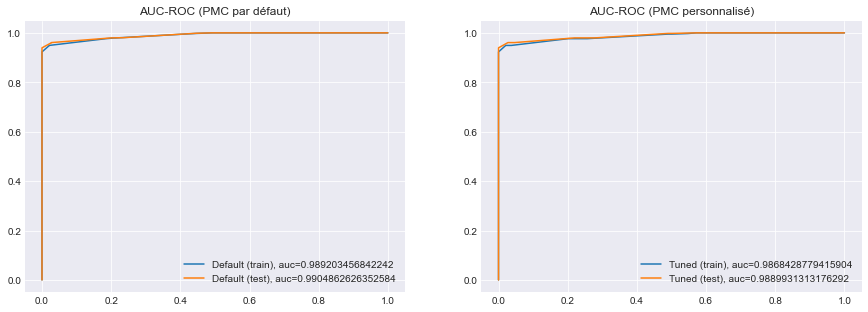

In [150]:
plt.figure(figsize=(15,5))

# AUC-ROC des données train :
y_pred_DefaultPMC_train = defaultPMC.predict_proba(X_train)[::,1]
y_pred_ModelPMC_train = modelPMC.predict_proba(X_train)[::,1]
fpr_DefaultPMC_train, tpr_DefaultPMC_train, _ = roc_curve(y_train,  y_pred_DefaultPMC_train)
fpr_ModelPMC_train, tpr_ModelPMC_train, _ = roc_curve(y_train,  y_pred_ModelPMC_train)
auc_DefaultPMC_train = roc_auc_score(y_train, y_pred_DefaultPMC_train)
auc_ModelPMC_train = roc_auc_score(y_train, y_pred_ModelPMC_train)

# AUC-ROC des données test :
y_pred_DefaultPMC = defaultPMC.predict_proba(X_test)[::,1]
y_pred_ModelPMC = modelPMC.predict_proba(X_test)[::,1]
fpr_DefaultPMC, tpr_DefaultPMC, _ = roc_curve(y_test,  y_pred_DefaultPMC)
fpr_ModelPMC, tpr_ModelPMC, _ = roc_curve(y_test,  y_pred_ModelPMC)
auc_DefaultPMC = roc_auc_score(y_test, y_pred_DefaultPMC)
auc_ModelPMC = roc_auc_score(y_test, y_pred_ModelPMC)

# Affichage courbe ROC + AUC
plt.subplot(1, 2, 1)
plt.plot(fpr_DefaultPMC_train,tpr_DefaultPMC_train,label="Default (train), auc="+str(auc_DefaultPMC_train))
plt.plot(fpr_DefaultPMC,tpr_DefaultPMC,label="Default (test), auc="+str(auc_DefaultPMC))
plt.title("AUC-ROC (PMC par défaut)")
plt.legend(loc=4)

plt.subplot(1, 2, 2)
plt.plot(fpr_ModelPMC_train,tpr_ModelPMC_train,label="Tuned (train), auc="+str(auc_ModelPMC_train))
plt.plot(fpr_ModelPMC,tpr_ModelPMC,label="Tuned (test), auc="+str(auc_ModelPMC))
plt.title("AUC-ROC (PMC personnalisé)")
plt.legend(loc=4);

## K-Nearest Neighbors
### Entrainement

In [151]:
# Initialisation du modèle
knn = KNN()

# Entrainement
knn.fit(X_train,y_train)

# Evaluation des performances
knn_score_train = "%.3f" % knn.score(X_train, y_train)
knn_score_test = "%.3f" % knn.score(X_test, y_test)

print("PMC personnalisé :")
print(" - Train:",knn_score_train)
print(" - Test:",knn_score_test)

PMC personnalisé :
 - Train: 0.965
 - Test: 0.967


### Courbe ROC

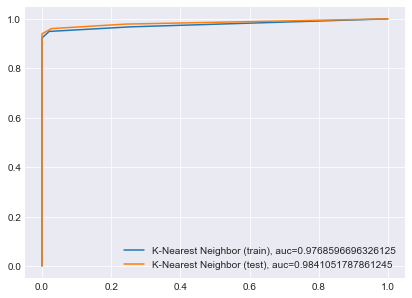

In [152]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
# AUC-ROC des données train :
y_pred_KNN_train = knn.predict_proba(X_train)[::,1]
fpr_KNN_train, tpr_KNN_train, _ = roc_curve(y_train, y_pred_KNN_train)
auc_KNN_train = roc_auc_score(y_train, y_pred_KNN_train)

# AUC-ROC des données test :
y_pred_KNN_test = knn.predict_proba(X_test)[::,1]
fpr_KNN, tpr_KNN, _ = roc_curve(y_test, y_pred_KNN_test)
auc_KNN = roc_auc_score(y_test, y_pred_KNN_test)

# Affichage courbe ROC + AUC
plt.plot(fpr_KNN_train,tpr_KNN_train,label="K-Nearest Neighbor (train), auc="+str(auc_KNN_train))
plt.plot(fpr_KNN,tpr_KNN,label="K-Nearest Neighbor (test), auc="+str(auc_KNN))
plt.legend(loc=4);

## Résultats

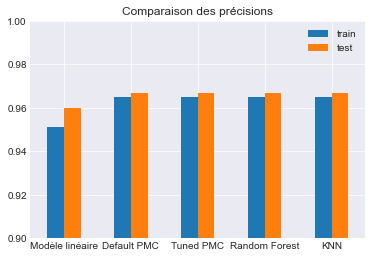

In [153]:
x = ["Modèle linéaire", "Default PMC", "Tuned PMC", "Random Forest", "KNN"]
train_scores = [ldaScore_train, defaultPMC_score_train, modelPMC_score_train, RF_Score_train, knn_score_train]
test_scores = [ldaScore_test, defaultPMC_score_test, modelPMC_score_test, RF_Score_test, knn_score_test]

df = pd.DataFrame(data={'train': train_scores, 'test': test_scores}, index=x)
df=df.astype(float)
ax = df.plot(kind='bar', rot=0, title='Comparaison des précisions', figsize=(6, 4))
ax.margins(y=0.1)
ax.set_ylim(0.9, 1.0);

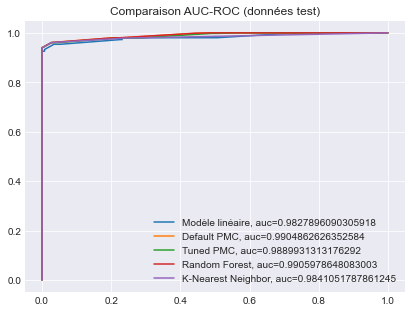

In [154]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(fpr_LDA,tpr_LDA,label="Modèle linéaire, auc="+str(auc_LDA))
plt.plot(fpr_DefaultPMC,tpr_DefaultPMC,label="Default PMC, auc="+str(auc_DefaultPMC))
plt.plot(fpr_ModelPMC,tpr_ModelPMC,label="Tuned PMC, auc="+str(auc_ModelPMC))
plt.plot(fpr_RF,tpr_RF,label="Random Forest, auc="+str(auc_RF))
plt.plot(fpr_KNN,tpr_KNN,label="K-Nearest Neighbor, auc="+str(auc_KNN))
plt.legend(loc=4)
plt.title("Comparaison AUC-ROC (données test)");

**Observations** :

- Les modèles de machine learning ont fourni des résultats très similaires : l'accuracy sur les données test est de **96%**. Le modèle linéaire est le moins performant.
- La sélection de feature basée sur la multi-colinéarité et l'importance des variables du Random Forest a permis d'améliorer la généralisation. Nous obtenons ainsi un ensemble de modèles dont le sur-apprentissage a été contrôlé.